In [1]:
# Import necessary libraries

import pandas as pd    
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
                                                 #                          io - Reading, saving, and displaying images.) 
from skimage.color import rgb2gray
    
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline

import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

from IPython.display import display

import cv2 as cv

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

In [2]:
# Mount Google drive so dataset can be accessed (The dataset file (monkeys_dataset.zip) is inside google drive.)
#from google.colab import drive
#drive.mount('/content/drive')

1. Import the libraries, load dataset, print shape of data, visualize the  images in dataset

In [3]:
trainImg = [] 
trainLabel = []

trainImg=np.load('images.npy')
trainLabeldf=pd.read_csv('Labels.csv')

display(trainLabeldf.head())
display(trainLabeldf.Label.value_counts())
display(trainLabeldf.shape)

display(trainImg.shape)

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

(4750, 1)

(4750, 128, 128, 3)

Loaded the Label data into a dataframe. 
Loaded the Image data into a List
There are 4750 labelled images - Each Image is 128x128 in size
There are 12 plant species in the labels for this 4750 images

In [4]:
def gaussImage(inImageArray):
  gaussImageArray=[]
  for i in inImageArray: 
    gaussImage = cv.GaussianBlur(i,(5,5),0)
    gaussImageArray.append(gaussImage)
  gaussImageArray=np.asarray(gaussImageArray)
  return gaussImageArray  

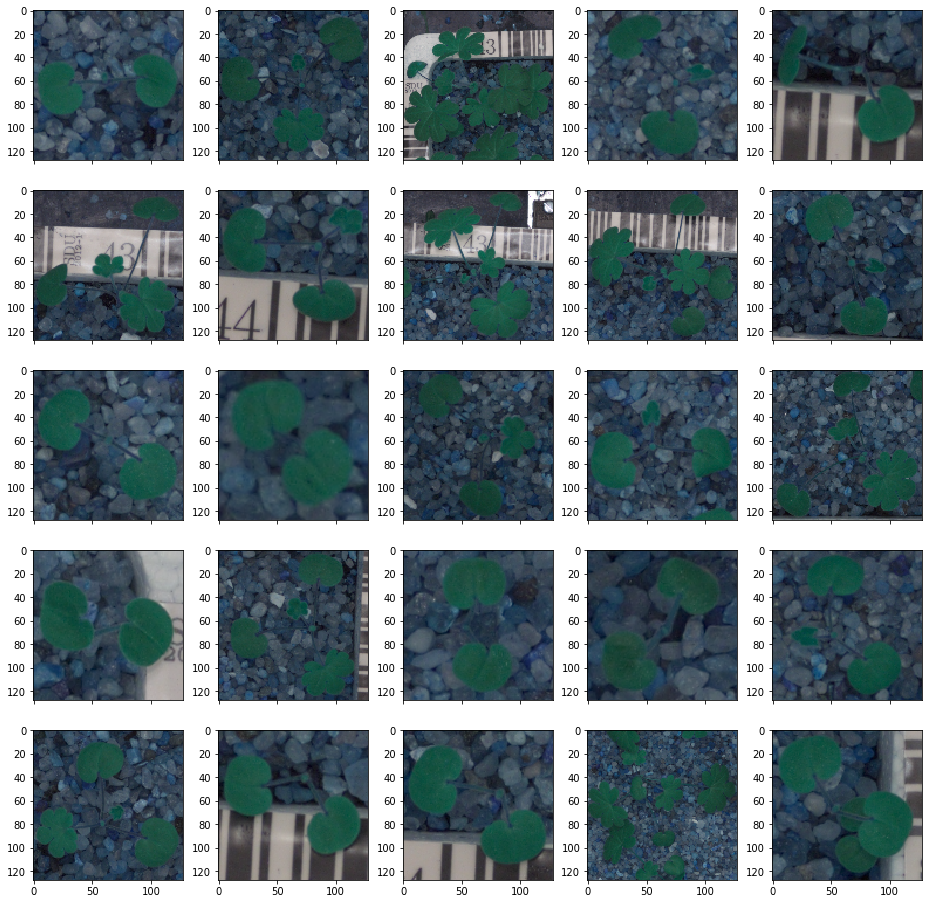

In [5]:
def normalizeImage(inImageArray):
  normImageArray=[]
  for i in inImageArray: 
    norm_img = np.zeros((128,128))
    final_img = cv.normalize(i,  norm_img, 0, 255, cv.NORM_MINMAX)
    normImageArray.append(final_img)
  normImageArray=np.asarray(normImageArray)
  return normImageArray


def showImages(fromImage,imageArray,gray):
  fig, axs = plt.subplots(nrows=5,ncols=5, sharex=True, figsize=(16, 16))
  imgCount=fromImage
  for x in range(5):
    imgCount=imgCount+x
    for y in range(5):
      imgCount=imgCount+y
      if (gray):
        axs[x][y].imshow(imageArray[imgCount],cmap='gray', vmin=0, vmax=255)
      else:
        axs[x][y].imshow(imageArray[imgCount])

def displayImageSideBySide(fromImage,origImageArray,normImageArray,gaussImageArray,gray):
  fig, axs = plt.subplots(nrows=1,ncols=3, sharex=True, figsize=(25, 5))
  imgCount=fromImage
  if (gray):
    axs[0].imshow(origImageArray[imgCount],cmap='gray')
    axs[1].imshow(normImageArray[imgCount],cmap='gray')
    axs[2].imshow(gaussImageArray[imgCount],cmap='gray')
  else:
    axs[0].imshow(origImageArray[imgCount])
    axs[1].imshow(normImageArray[imgCount])
    axs[2].imshow(gaussImageArray[imgCount])

showImages(0,trainImg,False)

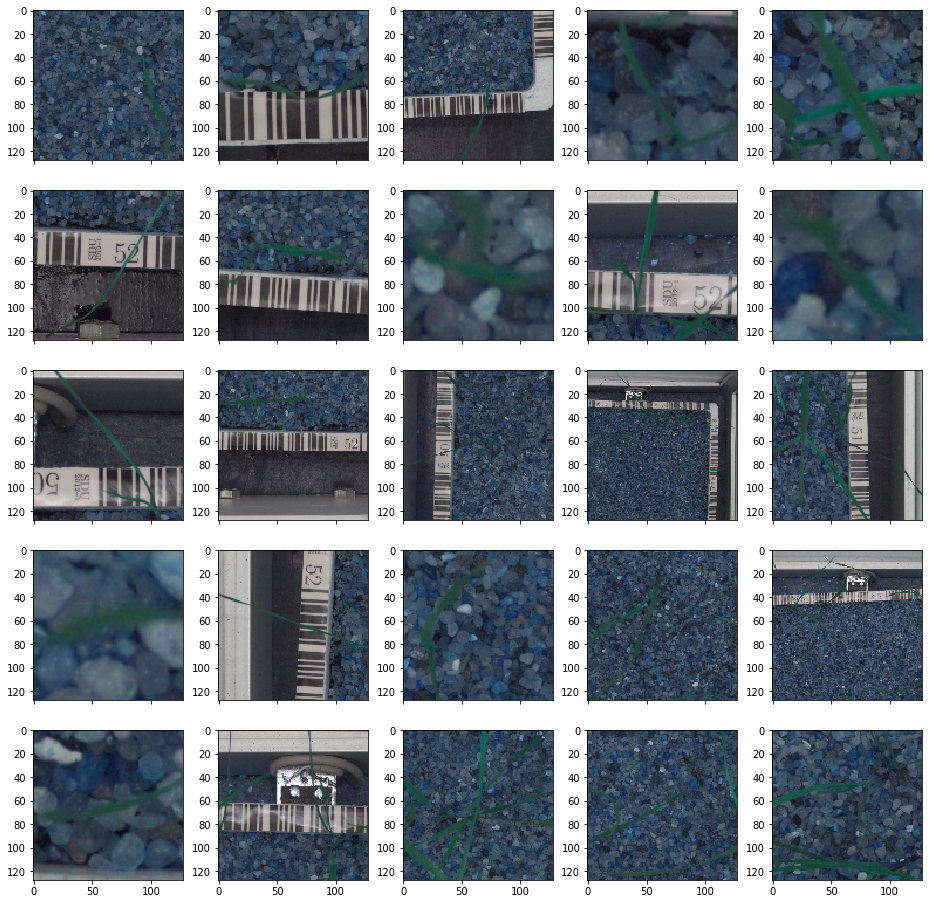

In [6]:
showImages(4000,trainImg,False)

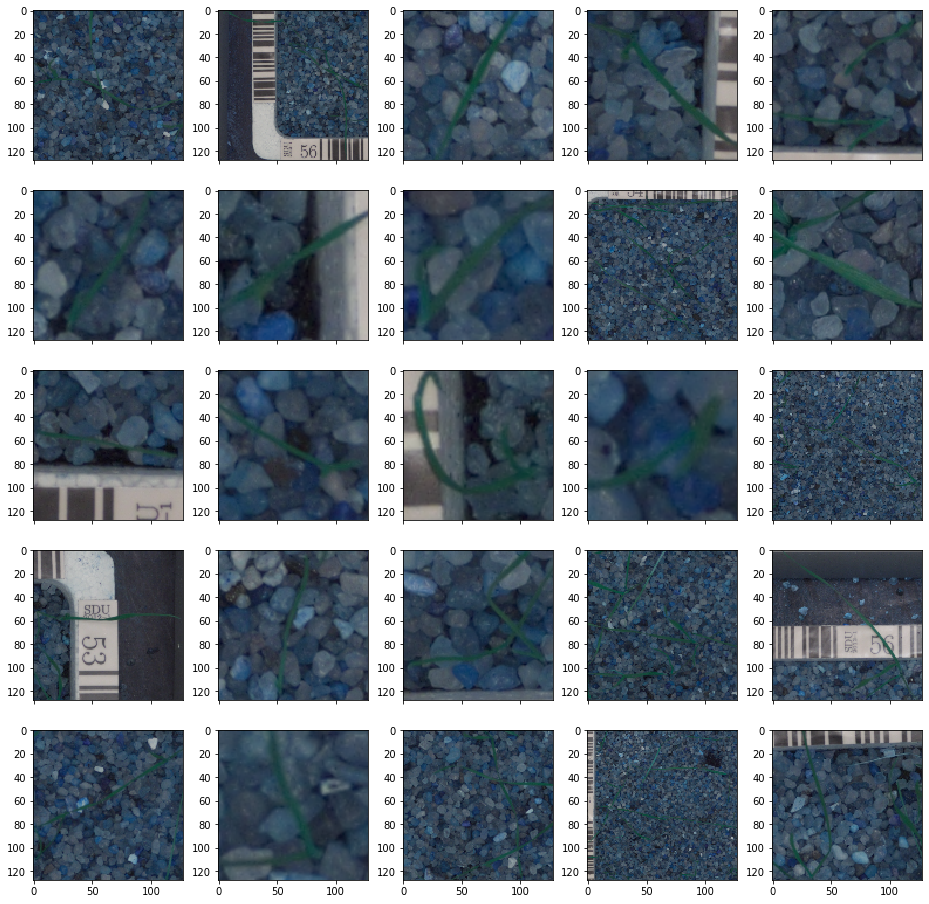

In [7]:
showImages(4096,trainImg,False)

**Data Pre-processing:**

a. Normalization.

b. Gaussian Blurring.

c. Visualize data after pre-processing. 

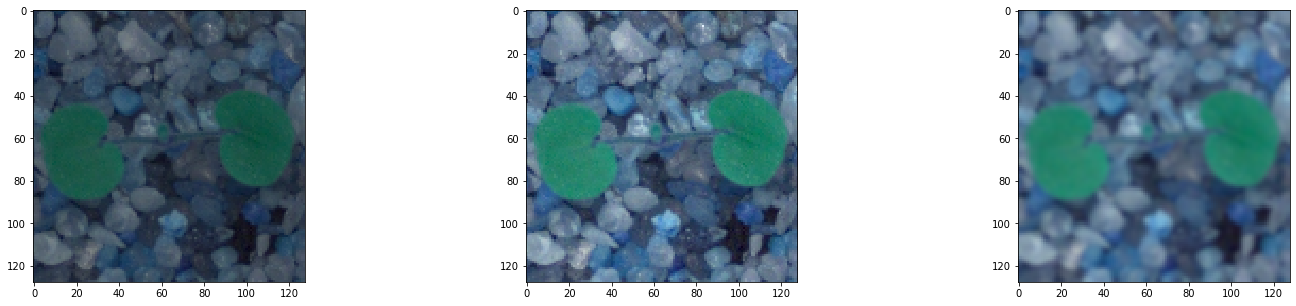

In [8]:
normalTrainImg = normalizeImage(trainImg)
gaussTrainImg = gaussImage(normalTrainImg)
displayImageSideBySide(0,trainImg,normalTrainImg,gaussTrainImg,False)

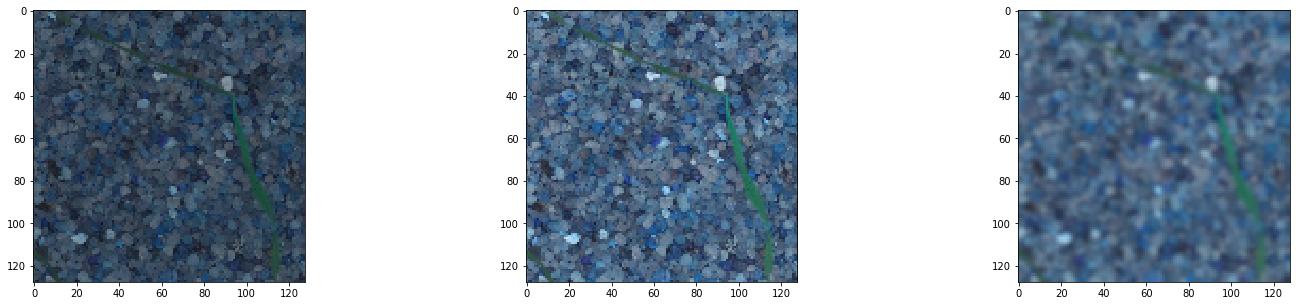

In [9]:
displayImageSideBySide(4000,trainImg,normalTrainImg,gaussTrainImg,False)

#### Tried to execute normalization, followed by Gaussian blurring on the images - There are no standout features so more attempts are made to see if we can get better features

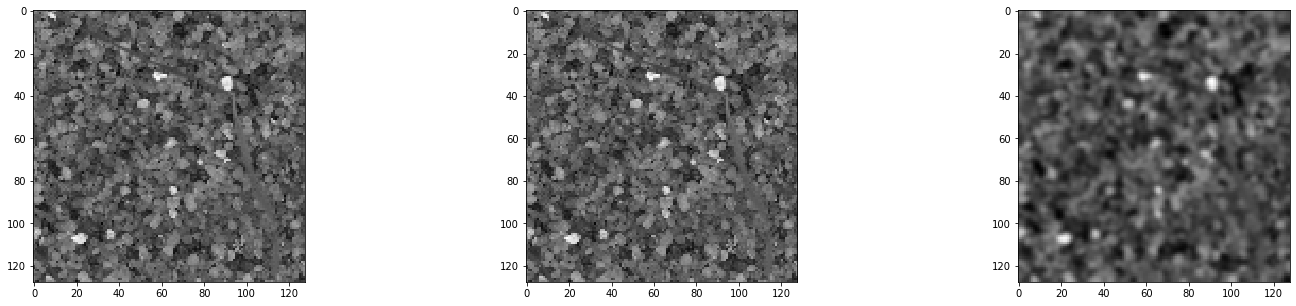

In [10]:
def toGrayScale(inImageArray):
  gtrainImg=[]
  for i in inImageArray: 
    img = rgb2gray(i)
    gtrainImg.append(img)
  gtrainImg=np.asarray(gtrainImg)
  return gtrainImg

def noiseReduction(inImageArray):
    dtrainImg=[]
    inImageArray = inImageArray.reshape(inImageArray.shape[0], 128, 128, 1)
    inImageArray = inImageArray.astype('float32')
    for i in inImageArray:
        image = i
        image=(image*255).astype(np.uint8)
        img=cv.fastNlMeansDenoising(image)
        dtrainImg.append(img)
    dtrainImg=np.asarray(dtrainImg)
    return dtrainImg

def completeDenoise(inImageArray):
    gtrainImg=[]
    for i in inImageArray: 
        hsv = cv.cvtColor(i,cv.COLOR_BGR2HSV)
        #GREEN PARAMETERS
        #lower = (36, 25, 25)
        #upper = (70, 255,255)
        lower = (25,40,50)
        upper = (75,255,255)
        img=hsv
        mask = cv.inRange(hsv,lower,upper)
        imask = mask>0
        green = np.zeros_like(img, np.uint8)
        green[imask] = img[imask]
        img=rgb2gray(green)
        gtrainImg.append(img)
    gtrainImg=np.asarray(gtrainImg)
    gtrainImg=noiseReduction(gtrainImg)
    return gtrainImg

gtrainImg=toGrayScale(trainImg)

gnormalTrainImg = normalizeImage(gtrainImg)
ggaussTrainImg = gaussImage(gnormalTrainImg)

displayImageSideBySide(4000,gtrainImg,gnormalTrainImg,ggaussTrainImg,True)

#### Convert to GrayScale and from the naked eye the plant is blurred into the background
#### Consider using a method that will extract the Green,  Followed by removing the background and than removing the noise hopefully without impacting the real plant

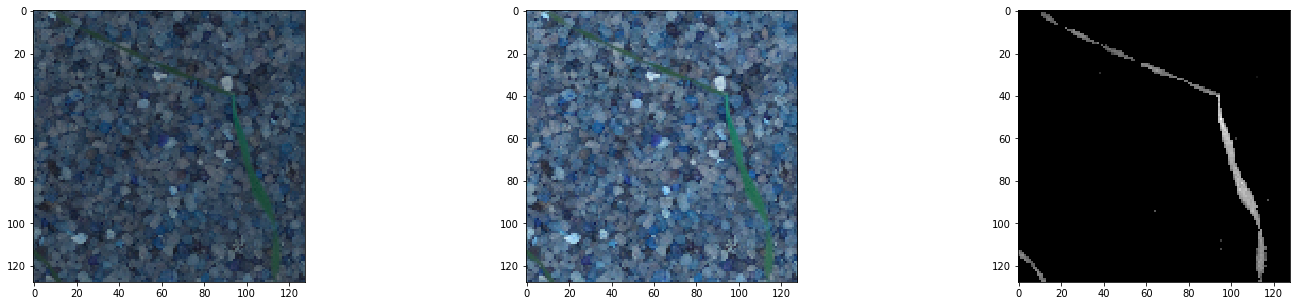

In [11]:
denoisedImg=completeDenoise(normalTrainImg)
displayImageSideBySide(4000,trainImg,normalTrainImg,denoisedImg,True)

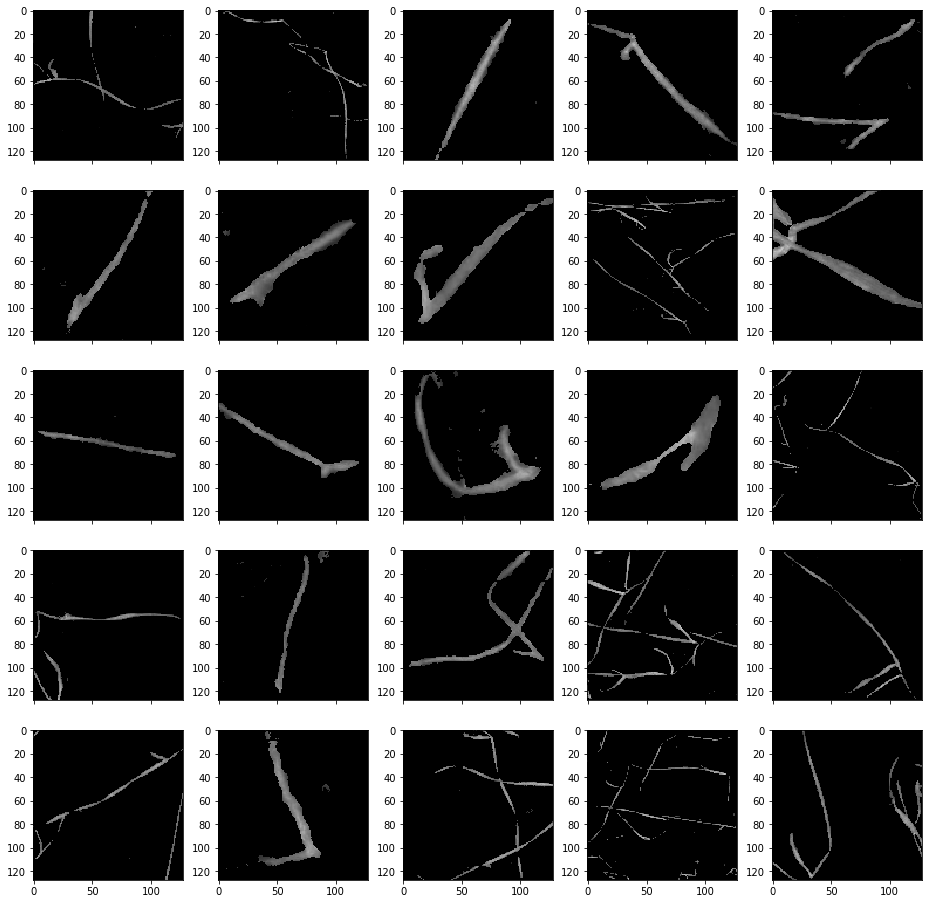

In [12]:
showImages(4096,denoisedImg,True)

**3. Make data compatible:**

Shape of y_train: (4750, 12)
One value of y_train: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


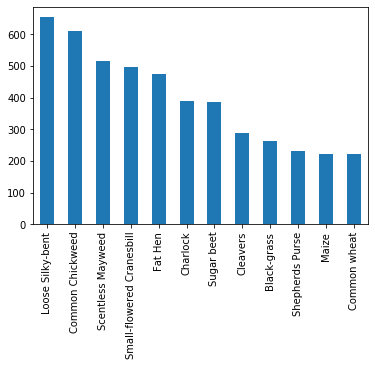

In [13]:
trainLabeldf["Label"] = trainLabeldf["Label"].astype('category')
trainLabeldf["LabelID"] = trainLabeldf["Label"].cat.codes

Y_train_initial = trainLabeldf['LabelID'].values
Y_train_lab = utils.to_categorical(Y_train_initial, num_classes=12)

print("Shape of y_train:", Y_train_lab.shape)
print("One value of y_train:", Y_train_lab[0])

trainLabeldf.Label.value_counts().plot(kind='bar')

trainLabelsdf=trainLabeldf.drop_duplicates(subset ="Label") 

trainLabelsdf=trainLabelsdf.sort_values(by=['LabelID'], ascending=True)

labelList = trainLabelsdf["Label"].tolist()
print(labelList)

In [14]:
X_train=denoisedImg
# Split the train and validation sets 
# First split training and testing with 0.3 (train/test)
# stratify for unbalanced classification
X_train_init, X_test, Y_train_init, Y_test = train_test_split(X_train, Y_train_lab, test_size=0.3, random_state=42,stratify = Y_train_lab)
# Further split training and validation fromt the 0.7 on the previous step with 0.5 (so 50/50 training and validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_init, Y_train_init, test_size=0.5, random_state=42,stratify = Y_train_init )

In [15]:
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)
print("X_val shape:",X_val.shape)
print("Y_val shape:",Y_val.shape)
print("X_test shape:",X_test.shape)
print("Y_test shape:",Y_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

print("X_train shape:", X_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_test:", X_val.shape[0])
print("Max value in X_train:", X_train.max())
print("Min value in X_train:", X_train.min())

X_train shape: (1662, 128, 128)
Y_train shape: (1662, 12)
X_val shape: (1663, 128, 128)
Y_val shape: (1663, 12)
X_test shape: (1425, 128, 128)
Y_test shape: (1425, 12)
X_train shape: (1662, 128, 128)
Images in X_train: 1662
Images in X_test: 1663
Max value in X_train: 0.8
Min value in X_train: 0.0


In [16]:
X_test_flat=X_test

print("Reshaping the X_train, X_test, X_val")
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 1)

print("X_train shape:",X_train.shape)
print("X_val shape:",X_val.shape)
print("X_test shape:",X_test.shape)

Reshaping the X_train, X_test, X_val
X_train shape: (1662, 128, 128, 1)
X_val shape: (1663, 128, 128, 1)
X_test shape: (1425, 128, 128, 1)


#### 4. Building CNN: 
##### a. Define layers.
##### b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

In [17]:
# We will build a model
# 2 Convolutions and a Pool
# 2 Convolutions and a Pool
# 2 Convolutions and a Pool
# Flatten
# Dense Neural 
# Dense Neural
# Softmax

def construct_model():
    model = Sequential()    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))

    model.add(Dense(12, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def sconstruct_model():
    smodel = Sequential()    
    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
    
    smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))

    smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
    
    smodel.add(Flatten())

    smodel.add(Dense(256, activation='relu'))

    smodel.add(Dense(12, activation='softmax'))
    #optimizer = Adam(lr=0.001)
    
    smodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()
    return smodel

def cconstruct_model(learningRate):
    smodel = Sequential()    
    
    smodel.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
    smodel.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
        
    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))
    
    smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    smodel.add(MaxPool2D((2, 2)))

    smodel.add(Flatten())

    smodel.add(Dense(256, activation='relu'))
    smodel.add(Dense(256, activation='relu'))

    smodel.add(Dense(12, activation='softmax'))
    optimizer = Adam(lr=learningRate)
    
    smodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    smodel.summary()
    return smodel

model=cconstruct_model(0.001)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       7

#### 5. Fit and evaluate model and print confusion matrix.

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.005)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',monitor='accuracy',verbose=0, save_best_only=True)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint('model2.h5',monitor='accuracy',verbose=0, save_best_only=True)
checkpoint3 = tf.keras.callbacks.ModelCheckpoint('model3.h5',monitor='accuracy',verbose=0, save_best_only=True)

In [19]:
# Use earlystopping
model.fit( x=X_train, y=Y_train,epochs=50,validation_data=(X_val, Y_val), callbacks=[callback,checkpoint],verbose=1)

Epoch 1/50
52/52 [==============================] - 51s 984ms/step - loss: 2.4141 - accuracy: 0.1739 - val_loss: 2.1458 - val_accuracy: 0.2255
Epoch 2/50
52/52 [==============================] - 50s 967ms/step - loss: 1.8103 - accuracy: 0.3526 - val_loss: 1.5094 - val_accuracy: 0.4456
Epoch 3/50
52/52 [==============================] - 49s 942ms/step - loss: 1.5281 - accuracy: 0.4380 - val_loss: 1.4436 - val_accuracy: 0.4678
Epoch 4/50
52/52 [==============================] - 51s 976ms/step - loss: 1.2873 - accuracy: 0.5289 - val_loss: 1.4512 - val_accuracy: 0.4678
Epoch 5/50
52/52 [==============================] - 50s 968ms/step - loss: 1.0811 - accuracy: 0.6101 - val_loss: 1.2827 - val_accuracy: 0.5755
Epoch 6/50
52/52 [==============================] - 54s 1s/step - loss: 0.7639 - accuracy: 0.7190 - val_loss: 1.3211 - val_accuracy: 0.5845
Epoch 7/50
52/52 [==============================] - 52s 1s/step - loss: 0.5705 - accuracy: 0.7888 - val_loss: 1.2355 - val_accuracy: 0.5947
Epoch

45/45 [==============================] - 9s 203ms/step - loss: 3.3969 - accuracy: 0.6168
Test accuracy [3.3969151973724365, 0.6168420910835266]
52/52 [==============================] - 11s 215ms/step - loss: 0.0084 - accuracy: 0.9976
Train accuracy [0.008421259000897408, 0.9975932836532593]
52/52 [==============================] - 11s 213ms/step - loss: 3.1012 - accuracy: 0.6170
Validation accuracy [3.1011550426483154, 0.6169573068618774]


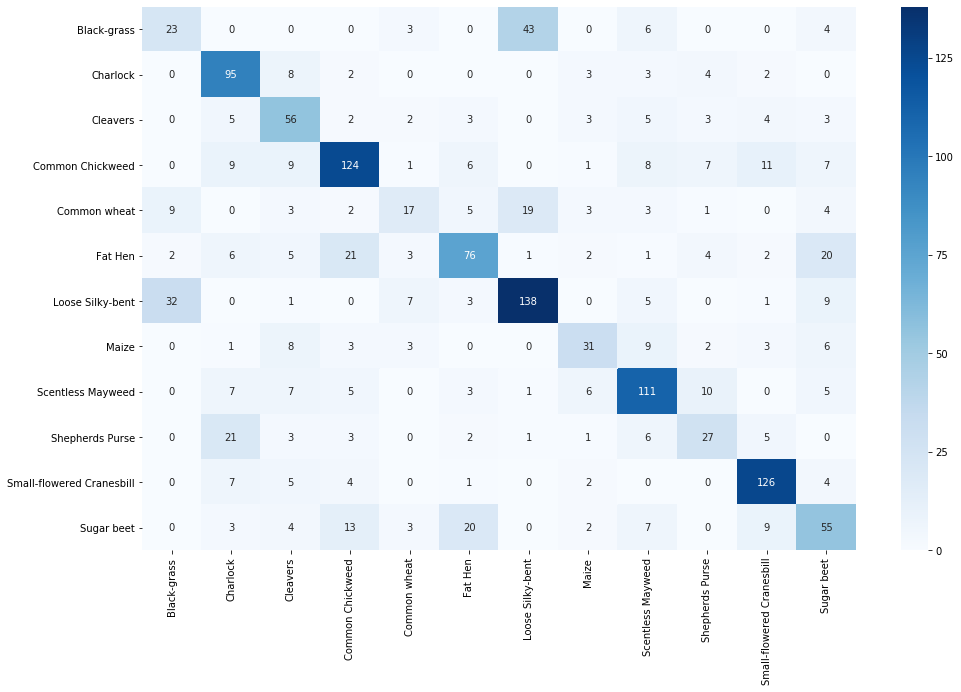

In [18]:
def confusionMatrix(inModel):
    print("Test accuracy",inModel.evaluate(X_test, Y_test))
    print("Train accuracy",inModel.evaluate(X_train, Y_train))
    print("Validation accuracy",inModel.evaluate(X_val, Y_val))
    
    # PREDICTIONS
    Y_pred = inModel.predict(X_test)
    Y_predicted = np.argmax(Y_pred, axis = 1) 
    Y_true = np.argmax(Y_test, axis = 1) 

    cmatrix = confusion_matrix(Y_true, Y_predicted)
    #print(cmatrix)
    
    cm_df = pd.DataFrame(cmatrix,labelList,labelList)                      
    plt.figure(figsize=(16,10))  
    sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
    
    return Y_pred


model = load_model('model.h5')
Y_pred=confusionMatrix(model)

#### Initial run was an overfit on the training data - with low accuracy on the validation and testing data set. All the requested x_test were predicted accurately

#### 6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. 

In [19]:
X_test_image = X_test.reshape(X_test.shape[0], 128, 128)

def showImage(position):
    print("Predicted",Y_pred[position].argmax(),"Actual ",Y_test[position].argmax())
    plt.imshow(X_test_image[position],cmap='gray')

Predicted 2 Actual  2


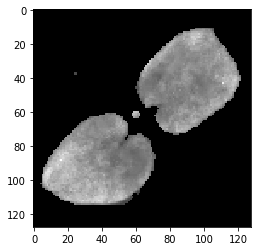

In [59]:
showImage(2)

Predicted 1 Actual  1


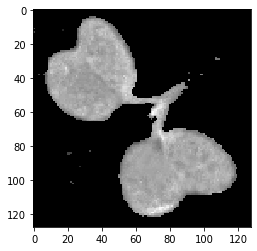

In [60]:
showImage(3)

Predicted 1 Actual  1


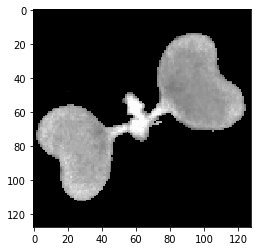

In [61]:
showImage(33)

Predicted 5 Actual  5


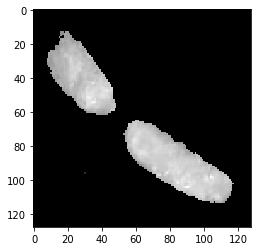

In [62]:
showImage(36)

Predicted 1 Actual  1


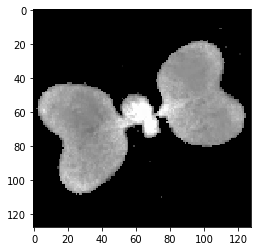

In [63]:
showImage(59)

# Interpreting Results

## Initial Experiment
We carried out the instructions requested for this exercise - and added additional image-pre-processing steps.
At the end of this notebook **APPENDIX A** - I have exectued the model training/prediction without the image-pre-processing steps.

In Section 2 - I added a ImageDataGenerator to try to overcome the overfitting problem

In Section 3 - I added Class Weights to see if I can get better prediction (due to Class Imbalance)


## Section 2

In [27]:
## Reading the Literature on Image Processing/Training it's suggested to use DataGenerator - which helps with Overfitting

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0025)
model=cconstruct_model(0.0008)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(  
        rotation_range=90,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

model.fit(datagen.flow(X_train, Y_train), epochs=75, validation_data=(X_val, Y_val), callbacks=[callback,checkpoint2],verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 27, 27, 128)      

45/45 [==============================] - 12s 263ms/step - loss: 0.3812 - accuracy: 0.8807
Test accuracy [0.3811899423599243, 0.8807017803192139]
52/52 [==============================] - 14s 268ms/step - loss: 0.2413 - accuracy: 0.9019
Train accuracy [0.24125166237354279, 0.9019253849983215]
52/52 [==============================] - 14s 269ms/step - loss: 0.3647 - accuracy: 0.8827
Validation accuracy [0.3647363781929016, 0.8827420473098755]


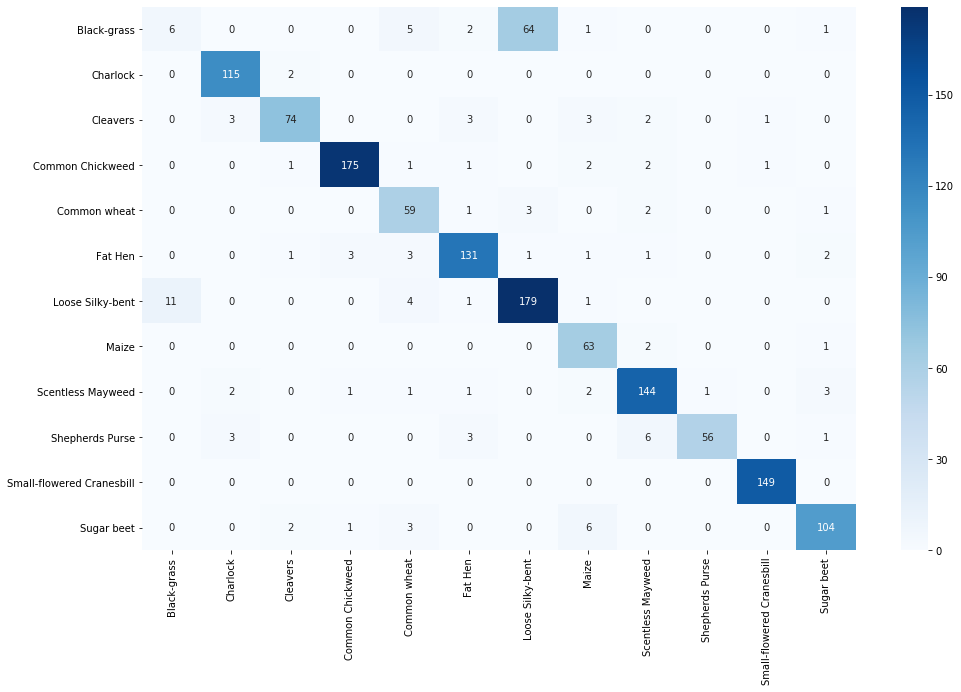

In [28]:
model = load_model('model2.h5')
Y_pred=confusionMatrix(model)

#### With ImageDataGenerator the model wasn't overfitting - and had good accuracy overall - but Black Grass was wrongly idenitified as Loose Silky Bent
#### From the perspective of the project both Loose Silky Bent and Black Grass are weeds - but it would be best to get good accuracy and prediction

Predicted 2 Actual  2


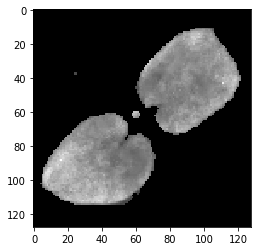

In [64]:
showImage(2)

Predicted 1 Actual  1


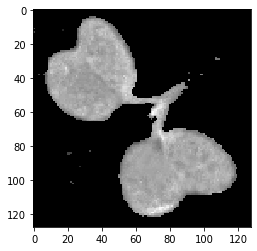

In [65]:
showImage(3)

Predicted 1 Actual  1


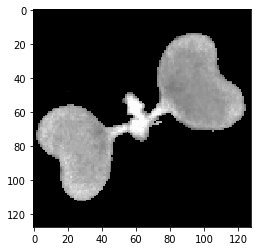

In [66]:
showImage(33)

Predicted 5 Actual  5


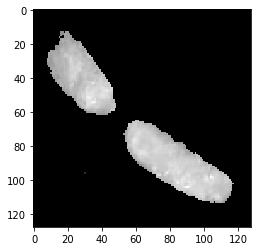

In [67]:
showImage(36)

Predicted 1 Actual  1


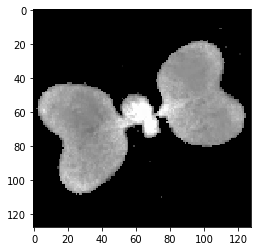

In [68]:
showImage(59)

## Section 3

### Reference to https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#### Create a Class Weight based on the formula provided - as there is class inbalance

In [34]:
traindf=pd.DataFrame(data=Y_train)

total=traindf.shape[0]

columns = list(traindf) 

weights = []
for i in columns: 
    count=traindf[i].sum()
    val=(1/count)*total/12.0
    weights.append(val)
    
print (weights)

cw = {0:1.5054347826086956,1:1.0183823529411764,
      2:1.3712871287128712,3:0.647196261682243,
      4:1.7756410256410255,5:0.8343373493975904,
      6:0.6048034934497816,7:1.7756410256410255,8:0.7694444444444445,
      9:0.8005780346820809,10:0.8005780346820809,11:1.0335820895522387}

[1.5054347826086956, 1.0183823529411764, 1.3712871287128712, 0.647196261682243, 1.7756410256410255, 0.8343373493975904, 0.6048034934497816, 1.7756410256410255, 0.7694444444444445, 1.7098765432098766, 0.8005780346820809, 1.0335820895522387]


In [42]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=4, 
                        verbose=1, 
                        factor=0.75, 
                        min_lr=0.00001)

model=cconstruct_model(0.002)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0025)

model.fit(datagen.flow(X_train, Y_train), epochs=100, validation_data=(X_val, Y_val), callbacks=[checkpoint3,rlr],class_weight=cw,verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 27, 27, 128)      

Epoch 84/100
52/52 [==============================] - 66s 1s/step - loss: 0.3019 - accuracy: 0.8809 - val_loss: 0.4229 - val_accuracy: 0.8599 - lr: 2.0023e-04
Epoch 85/100
52/52 [==============================] - 67s 1s/step - loss: 0.2974 - accuracy: 0.8785 - val_loss: 0.4041 - val_accuracy: 0.8677 - lr: 2.0023e-04
Epoch 86/100
52/52 [==============================] - 67s 1s/step - loss: 0.2902 - accuracy: 0.8887 - val_loss: 0.4146 - val_accuracy: 0.8653 - lr: 2.0023e-04
Epoch 87/100
52/52 [==============================] - 67s 1s/step - loss: 0.2909 - accuracy: 0.8803 - val_loss: 0.4488 - val_accuracy: 0.8527 - lr: 2.0023e-04
Epoch 88/100
52/52 [==============================] - 66s 1s/step - loss: 0.2924 - accuracy: 0.8748 - val_loss: 0.4039 - val_accuracy: 0.8719 - lr: 2.0023e-04
Epoch 89/100
52/52 [==============================] - 67s 1s/step - loss: 0.2774 - accuracy: 0.8881 - val_loss: 0.4142 - val_accuracy: 0.8641 - lr: 2.0023e-04
Epoch 90/100
52/52 [==========================

45/45 [==============================] - 8s 173ms/step - loss: 0.4850 - accuracy: 0.8632
Test accuracy [0.48495760560035706, 0.8631578683853149]
52/52 [==============================] - 10s 188ms/step - loss: 0.2511 - accuracy: 0.9007
Train accuracy [0.2510540783405304, 0.9007220268249512]
52/52 [==============================] - 11s 208ms/step - loss: 0.4297 - accuracy: 0.8563
Validation accuracy [0.4296874403953552, 0.8562838435173035]


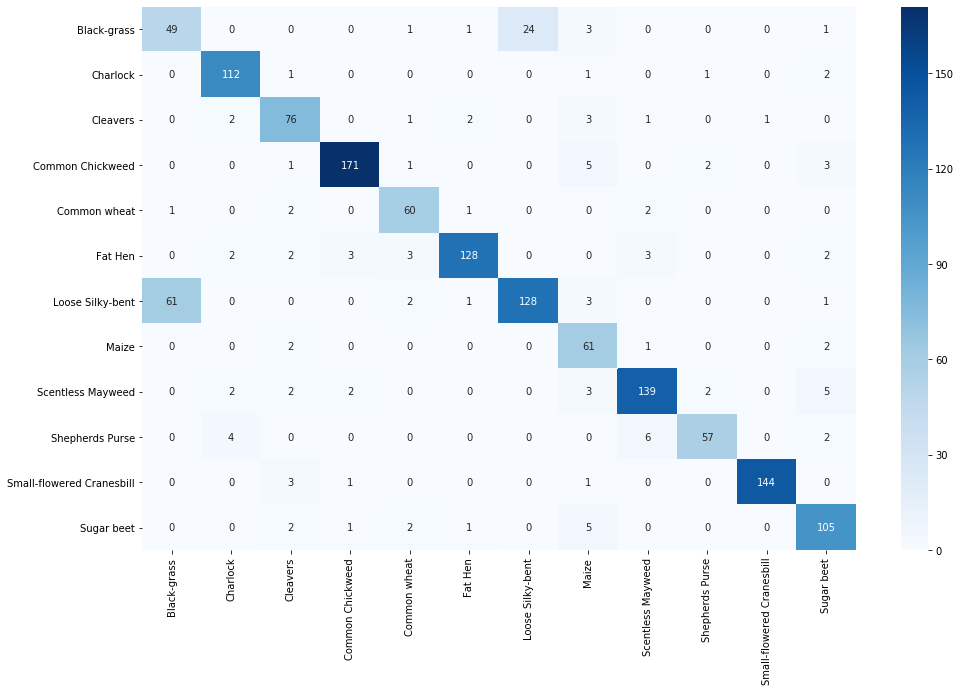

In [88]:
model = load_model('model3.h5')
Y_pred=confusionMatrix(model)

#### We tried to use Class Weights as the data was unbalanced - and we had good accuracy and more Black Grass being identified correctly

Predicted 2 Actual  2


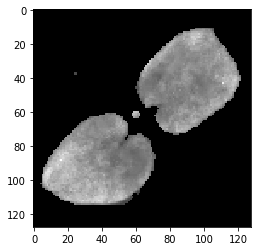

In [44]:
showImage(2)

Predicted 1 Actual  1


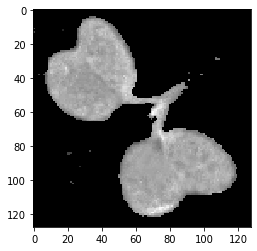

In [45]:
showImage(3)

Predicted 1 Actual  1


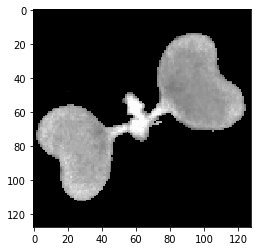

In [46]:
showImage(33)

Predicted 11 Actual  5


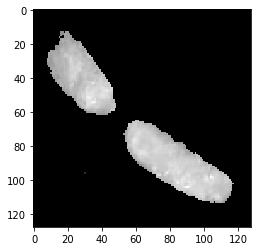

In [47]:
showImage(36)

Predicted 1 Actual  1


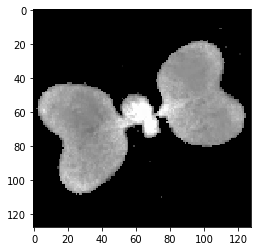

In [48]:
showImage(59)

# Appendix A - RGB without preprocessing

### Experiment with using RGB without - pre-processing 
### This image is stored in gaussTrainImg - the original image set - normalized and Gaussian Blurring applied 

In [46]:
X2_train=gaussTrainImg
# Split the train and validation sets 
# First split training and testing with 0.3 (train/test)
# stratify for unbalanced classification
X2_train_init, X2_test, Y2_train_init, Y2_test = train_test_split(X2_train, Y_train_lab, test_size=0.3, random_state=42,stratify = Y_train_lab)
# Further split training and validation fromt the 0.7 on the previous step with 0.5 (so 50/50 training and validation)
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2_train_init, Y2_train_init, test_size=0.5, random_state=42,stratify = Y2_train_init )

print("X_train shape:",X2_train.shape)
print("Y_train shape:",Y2_train.shape)
print("X_val shape:",X2_val.shape)
print("Y_val shape:",Y2_val.shape)
print("X_test shape:",X2_test.shape)
print("Y_test shape:",Y2_test.shape)

X2_train = X2_train.astype('float32')
X2_test = X2_test.astype('float32')
X2_val = X2_val.astype('float32')
X2_train /= 255
X2_test /= 255
X2_val /= 255

print("X_train shape:", X2_train.shape)
print("Images in X_train:", X2_train.shape[0])
print("Images in X_test:", X2_val.shape[0])
print("Max value in X_train:", X2_train.max())
print("Min value in X_train:", X2_train.min())

print("Reshaping the X_train, X_test, X_val")
X2_train = X2_train.reshape(X2_train.shape[0], 128, 128, 3)
X2_test = X2_test.reshape(X2_test.shape[0], 128, 128, 3)
X2_val = X2_val.reshape(X2_val.shape[0], 128, 128, 3)

print("X_train shape:",X2_train.shape)
print("X_val shape:",X2_val.shape)
print("X_test shape:",X2_test.shape)

X_train shape: (1662, 128, 128, 3)
Y_train shape: (1662, 12)
X_val shape: (1663, 128, 128, 3)
Y_val shape: (1663, 12)
X_test shape: (1425, 128, 128, 3)
Y_test shape: (1425, 12)
X_train shape: (1662, 128, 128, 3)
Images in X_train: 1662
Images in X_test: 1663
Max value in X_train: 1.0
Min value in X_train: 0.0
Reshaping the X_train, X_test, X_val
X_train shape: (1662, 128, 128, 3)
X_val shape: (1663, 128, 128, 3)
X_test shape: (1425, 128, 128, 3)


In [24]:
model=sconstruct_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.005)
checkpoint4 = tf.keras.callbacks.ModelCheckpoint('model4.h5',monitor='accuracy',verbose=0, save_best_only=True)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(  
        rotation_range=90,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X2_train)

model.fit(datagen.flow(X2_train, Y2_train), epochs=75, validation_data=(X2_val, Y2_val), callbacks=[callback,checkpoint4],verbose=1)

Epoch 1/75
52/52 [==============================] - 108s 2s/step - loss: 2.4445 - accuracy: 0.1300 - val_loss: 2.4191 - val_accuracy: 0.1299
Epoch 2/75
52/52 [==============================] - 113s 2s/step - loss: 2.4207 - accuracy: 0.1384 - val_loss: 2.4159 - val_accuracy: 0.1377
Epoch 3/75
52/52 [==============================] - 123s 2s/step - loss: 2.4201 - accuracy: 0.1510 - val_loss: 2.4099 - val_accuracy: 0.1575
Epoch 4/75
52/52 [==============================] - 121s 2s/step - loss: 2.1190 - accuracy: 0.3020 - val_loss: 1.8166 - val_accuracy: 0.3764
Epoch 5/75
52/52 [==============================] - 138s 3s/step - loss: 1.7532 - accuracy: 0.3851 - val_loss: 1.5126 - val_accuracy: 0.4720
Epoch 6/75
52/52 [==============================] - 141s 3s/step - loss: 1.6101 - accuracy: 0.4374 - val_loss: 1.3445 - val_accuracy: 0.5304
Epoch 7/75
52/52 [==============================] - 164s 3s/step - loss: 1.4905 - accuracy: 0.4844 - val_loss: 1.2380 - val_accuracy: 0.5809
Epoch 8/75
52

45/45 [==============================] - 20s 452ms/step - loss: 0.4104 - accuracy: 0.8596
Test accuracy [0.41042834520339966, 0.859649121761322]
52/52 [==============================] - 28s 531ms/step - loss: 0.3198 - accuracy: 0.8815
Train accuracy [0.31976789236068726, 0.8814681172370911]
52/52 [==============================] - 27s 517ms/step - loss: 0.4205 - accuracy: 0.8581
Validation accuracy [0.4204590320587158, 0.8580877780914307]


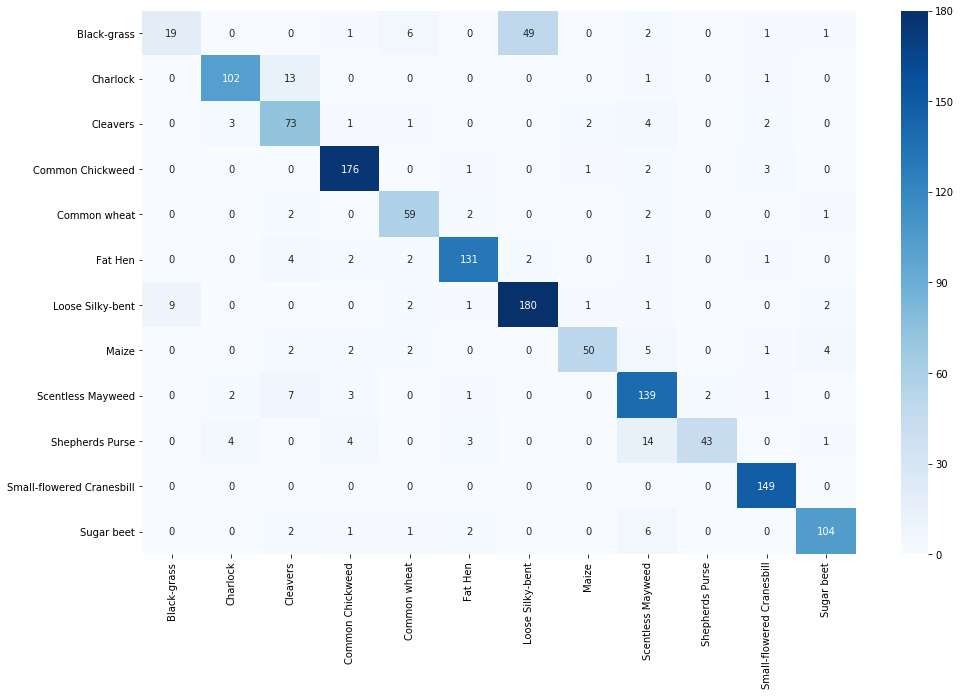

In [47]:
def confusionMatrix2(inModel):
    print("Test accuracy",inModel.evaluate(X2_test, Y2_test))
    print("Train accuracy",inModel.evaluate(X2_train, Y2_train))
    print("Validation accuracy",inModel.evaluate(X2_val, Y2_val))
    
    # PREDICTIONS
    Y2_pred = inModel.predict(X2_test)
    Y2_predicted = np.argmax(Y2_pred, axis = 1) 
    Y2_true = np.argmax(Y2_test, axis = 1) 

    cmatrix = confusion_matrix(Y2_true, Y2_predicted)
    #print(cmatrix)
    
    cm_df = pd.DataFrame(cmatrix,labelList,labelList)                      
    plt.figure(figsize=(16,10))  
    sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
    
    return Y2_pred

model = load_model('model4.h5')
Y2_pred=confusionMatrix2(model)

Predicted 2 Actual  2


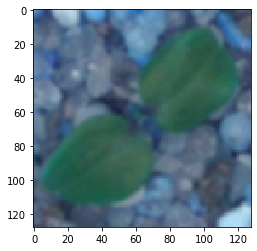

In [48]:
def showImage2(position):
    print("Predicted",Y2_pred[position].argmax(),"Actual ",Y2_test[position].argmax())
    plt.imshow(X2_test[position])
    
showImage2(2)

Predicted 1 Actual  1


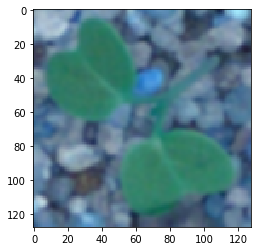

In [49]:
showImage2(3)

Predicted 1 Actual  1


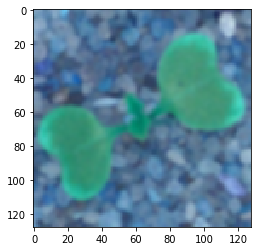

In [50]:
showImage2(33)

Predicted 5 Actual  5


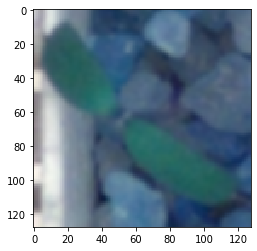

In [51]:
showImage2(36)

Predicted 1 Actual  1


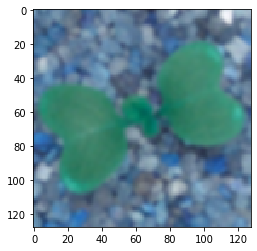

In [52]:
showImage2(59)

### Training time was longer for RGB images but achieved very similar results - though pre-processing was more intuitive ( denoise, Green Recognition and converting to grayscale).

# Appendix B

## Interpretability - using LIME 
#### From the Model - it would be great to explain how the model detected features to make a prediction.

https://github.com/marcotcr/lime

In [53]:
import lime
from lime import lime_image

In [54]:
explainer = lime_image.LimeImageExplainer()

In [55]:
%%time
explanation = explainer.explain_instance(X2_test[59], model.predict, top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 1min 44s, sys: 34.4 s, total: 2min 18s
Wall time: 19.1 s


## We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

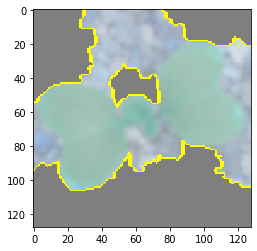

In [56]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

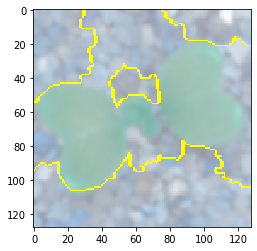

In [57]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

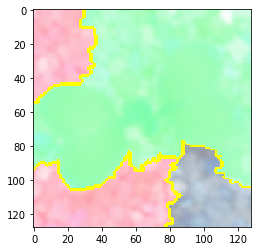

In [58]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [59]:
def getFalsePredictions():
    badPreds=[]
    bad=0
    for i in range(len(Y2_pred)): 
        predicted=Y2_pred[i].argmax()
        actual=Y2_test[i].argmax()
        if (predicted==actual):
            bad=bad+1
            #print("Skip")
        else:
            badPreds.append(i)
    return badPreds

badPredictions = getFalsePredictions()
print(badPredictions)

[10, 11, 22, 31, 44, 62, 63, 67, 70, 73, 75, 78, 82, 102, 116, 123, 129, 138, 144, 148, 159, 170, 177, 179, 193, 210, 211, 228, 231, 238, 242, 246, 256, 261, 264, 269, 272, 274, 280, 284, 304, 311, 327, 339, 354, 357, 358, 368, 376, 377, 380, 381, 389, 401, 408, 420, 433, 434, 438, 440, 444, 446, 447, 462, 477, 508, 519, 521, 530, 536, 550, 555, 558, 559, 560, 565, 572, 573, 587, 589, 599, 602, 603, 604, 612, 620, 628, 629, 642, 659, 666, 690, 692, 695, 697, 702, 709, 711, 721, 722, 730, 735, 738, 744, 746, 751, 766, 771, 774, 776, 778, 791, 793, 796, 805, 808, 823, 827, 830, 831, 832, 834, 849, 850, 851, 870, 876, 891, 892, 908, 925, 930, 938, 939, 948, 953, 955, 956, 969, 981, 982, 984, 987, 990, 999, 1000, 1035, 1042, 1043, 1046, 1062, 1065, 1081, 1088, 1112, 1128, 1140, 1141, 1147, 1158, 1162, 1163, 1167, 1170, 1172, 1193, 1205, 1209, 1219, 1221, 1232, 1246, 1250, 1251, 1258, 1262, 1273, 1274, 1289, 1292, 1295, 1297, 1301, 1306, 1311, 1322, 1324, 1325, 1336, 1340, 1348, 1350, 1351,

Predicted 0 Actual  6


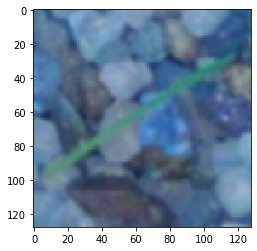

In [60]:
showImage2(1350)

In [61]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(X2_test[1350], model.predict, top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 1min 49s, sys: 35 s, total: 2min 24s
Wall time: 20.7 s


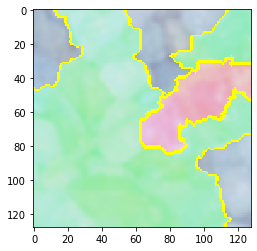

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Predicted 6 Actual  0


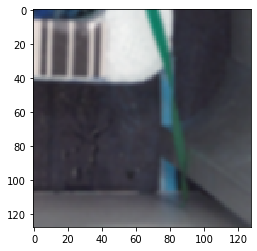

In [63]:
showImage2(1378)

In [64]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(X2_test[1378], model.predict, top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 2min 10s, sys: 43.8 s, total: 2min 53s
Wall time: 26.5 s


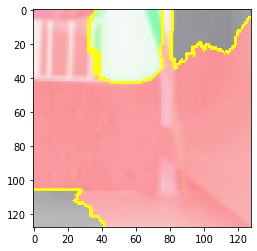

In [65]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### From the above LIME shows that for X_test[1378] and X_test[1350] the features detected are non obvious - as identification is not based on the actual plant and rather appears to be the background